# 1 - Importing Libraries

In [1]:
import os
import urllib 
import pickle
import cv2
import glob
import numpy as np
from numpy import genfromtxt
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage import io
import PIL
from PIL import Image
import scipy
import pandas as pd

# 2 - The Data Set

## 2.1 - Importing the data

The data set consists of 3.752 images collected while driving around the track and the corresponding steering angles

In [2]:
# Importing Steering Angles
Y = genfromtxt('Data/dataSteeringInt.csv', delimiter=',', dtype=(int))

# Importing Images
X_data = []
files = genfromtxt('Data/dataImages.csv', delimiter=',', dtype=None, encoding=None)

for myFile in files:
    filePath = 'Data/Images/Resized/jpeg/' + myFile
    image = Image.open(filePath).convert("L")
    im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
    img =  im_arr.reshape([120, 160, 1])
    X_data.append (img)
    
X = np.array(X_data)  

## 2.1 - Printing out the data

('X.shape: ', (3752, 120, 160, 1))
('Y.shape: ', (3752,))
[[[205]
  [210]
  [213]
  ...
  [165]
  [159]
  [253]]

 [[203]
  [207]
  [215]
  ...
  [173]
  [150]
  [246]]

 [[194]
  [199]
  [213]
  ...
  [186]
  [140]
  [242]]

 ...

 [[ 93]
  [ 87]
  [ 88]
  ...
  [ 88]
  [ 76]
  [ 70]]

 [[ 82]
  [ 75]
  [ 83]
  ...
  [ 94]
  [ 78]
  [ 68]]

 [[ 96]
  [ 95]
  [100]
  ...
  [ 83]
  [ 77]
  [ 39]]]


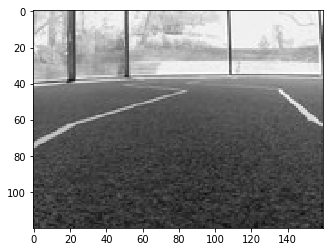

In [3]:
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
plt.imshow(X[0].squeeze(), cmap=plt.get_cmap('gray'))
print(X[0])

# 3 - Pre-processing

## 3.1 - Shuffling the data

In [4]:
def unison_shuffled_copies(X, Y):
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]

shuffled_X, shuffled_Y = unison_shuffled_copies(X,Y)
len(shuffled_X)

3752

## 3.2 - Splitting the data

The dataset is split into three:
1. Training Data to train the model
2. Validation Data to prevent overfitting
3. Test Data to measure the accuracy of the model

In [5]:
test_cutoff = int(len(X) * .8) # 80% of data used for training
val_cutoff = test_cutoff + int(len(X) * .1) # 10% of data used for validation and test data 

train_X, train_Y = shuffled_X[:test_cutoff], shuffled_Y[:test_cutoff]
val_X, val_Y = shuffled_X[test_cutoff:val_cutoff], shuffled_Y[test_cutoff:val_cutoff]
test_X, test_Y = shuffled_X[val_cutoff:], shuffled_Y[val_cutoff:]

len(train_X) + len(val_X) + len(test_X)

3752

## 3.3 - Augmenting the Training Data

To avoid bias and to increase the dataset we are going to flip the images and steering angles and add it to the data set. Additional techniques can be used including artificially adding noise to the data (cropping, adjusting hue, etc)

In [6]:
X_flipped = np.array([np.fliplr(i) for i in train_X])
Y_flipped = np.array([-i for i in train_Y])
train_X = np.concatenate([train_X, X_flipped])
train_Y = np.concatenate([train_Y, Y_flipped])
len(train_X)

6002

# 4 - Creating our Neural Network

## 4.1 - Importing Keras

In [7]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import callbacks

/home/ubuntu/anaconda3/envs/myenv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 4.3 - Convolution

We are going to have 5 convolution layers with 5x5 max-pooling and then two fully connected layers with a flattening layer between them

In [8]:
# Input
img_in = Input(shape=(120,160,1), name='img_in')
x = img_in

# Convolution Layers
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)
    
# Flattening Layer
x = Flatten(name='flattened')(x)

# Connected Layers
x = Dense(100, activation='linear')(x)
x = Dropout(.1)(x)
x = Dense(50, activation='linear')(x)
x = Dropout(.1)(x)

# Output
angle_out = Dense(1, activation='linear', name='angle_out')(x)

## 4.4 - Our Model

In [9]:
model = Model(inputs=[img_in], outputs=[angle_out])
model.compile(optimizer='adam', loss={'angle_out': 'mean_squared_error'})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 78, 24)        624       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 32)        19232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 17, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 8, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 6, 64)          36928     
_________________________________________________________________
flattened (Flatten)          (None, 1152)              0         
__________

# 5 - Training our Neural Network

## 5.1 - Destination and callbacks

The model will be saved only if validation loss improves, training will stop if the validation loss does not improve after 5 consecutive epochs

In [10]:
model_path = os.path.expanduser('~/carml_autopilot.hdf5')
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
callbacks_list = [save_best, early_stop]

## 5.2 - Train

In [11]:
model.fit(train_X, train_Y, batch_size=64, epochs=4, validation_data=(val_X, val_Y), callbacks=callbacks_list)

Train on 6002 samples, validate on 375 samples
Epoch 1/4
6002/6002 [==============================] - 14s - loss: 806.6403 - val_loss: 854.4356
Epoch 2/4
6002/6002 [==============================] - 14s - loss: 639.9554 - val_loss: 590.2827
Epoch 3/4
6002/6002 [==============================] - 14s - loss: 397.7334 - val_loss: 483.1638
Epoch 4/4
6002/6002 [==============================] - 14s - loss: 281.3721 - val_loss: 365.8731


# 6 - Performance

## 6.1 - Loading the Test Data

In [12]:
model = load_model(model_path)
test_P = model.predict(test_X)
test_P = test_P.reshape((test_P.shape[0],)) 

## 6.2 - Learned Relationship

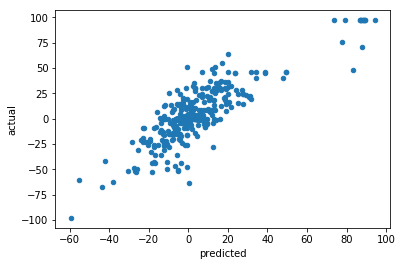

In [13]:
df = pd.DataFrame({'predicted':test_P, 'actual':test_Y})
ax = df.plot.scatter('predicted', 'actual')
#ax.set_ylabel("steering angle")

## 6.3 - Prediction Accuracy

Text(0,0.5,'steering angle')

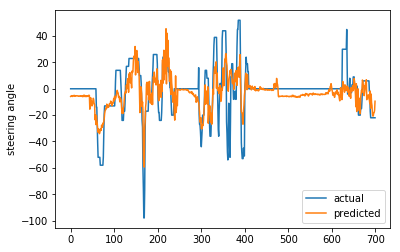

In [14]:
P = model.predict(X[:700])
P = P.reshape((P.shape[0],)) 

ax = pd.DataFrame({'predicted':P, 'actual':Y[:700]}).plot()
ax.set_ylabel("steering angle")

# 7 - Converting to CoreML

In [15]:
import coremltools

coreml_model = coremltools.converters.keras.convert(
    model, 
    input_names = "img_in", 
    image_input_names = "img_in", 
    output_names  = "angle_out")
coreml_model.author = 'George Karavias'
coreml_model.license = 'MIT'
coreml_model.short_description = 'Predicts a steering angle based on image containing lanes'
coreml_model.input_description['img_in'] = 'An image containing lanes'
coreml_model.output_description['angle_out'] = 'The steering angle'
coreml_model.save('Autopilot_v4.mlmodel')

0 : img_in, <keras.engine.topology.InputLayer object at 0x7fbe9216af10>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7fbe9216af50>
2 : conv2d_1__activation__, <keras.layers.core.Activation object at 0x7fbe1269fa10>
3 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7fbe9216af90>
4 : conv2d_2__activation__, <keras.layers.core.Activation object at 0x7fbe10b49650>
5 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7fbe9216a3d0>
6 : conv2d_3__activation__, <keras.layers.core.Activation object at 0x7fbe10adc210>
7 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x7fbe9216f5d0>
8 : conv2d_4__activation__, <keras.layers.core.Activation object at 0x7fbe10adc290>
9 : conv2d_5, <keras.layers.convolutional.Conv2D object at 0x7fbe9216f6d0>
10 : conv2d_5__activation__, <keras.layers.core.Activation object at 0x7fbe10adc2d0>
11 : flattened, <keras.layers.core.Flatten object at 0x7fbe9216f7d0>
12 : dense_1, <keras.layers.core.Dense object at 0x7fbe9216f910